In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 8
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)



In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

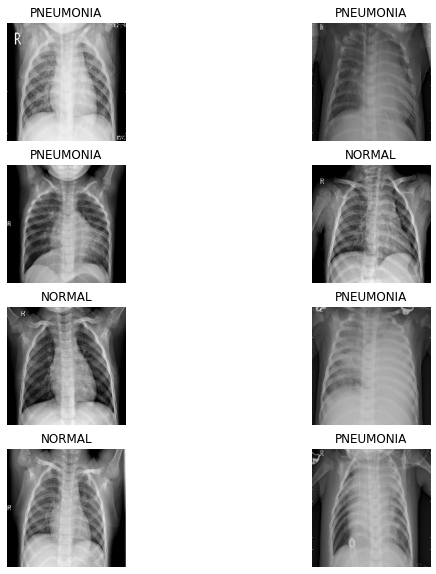

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
def residual_block(X, filters, reduce=False): # Residual Block의 구현
    # Residual Block의 시작 부분의 입력값을 저장
    X_shortcut = X
    
    # 첫 번째 합성곱 레이어
    if reduce: # 크기를 줄이기 위해 스트라이드를 2로 설정
        X = tf.keras.layers.Conv2D(filters, (3, 3), strides=(2, 2), padding='same')(X)
    else:
        X = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # 두 번째 합성곱 레이어
    X = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Shortcut Connection 조정
    if reduce: # 공간 차원을 메인 경로와 일치하게 변경하기 위해 1x1 합성곱을 스트라이드 2로 적용
        X_shortcut = tf.keras.layers.Conv2D(filters, (1, 1), strides=(2, 2))(X_shortcut)
        X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Shortcut Connection 더하기
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [20]:
def resnet18_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)):
    # 입력층
    X_input = tf.keras.layers.Input(input_shape)
    
    # 초기 합성곱 레이어
    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)
    X = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2))(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(X)
    
    # Residual Blocks 호출
    # Group 1
    X = residual_block(X, 64)
    X = residual_block(X, 64)
    
    # Group 2
    X = residual_block(X, 128, reduce=True)
    X = residual_block(X, 128)
    
    # Group 3
    X = residual_block(X, 256, reduce=True)
    X = residual_block(X, 256)
    
    # Group 4
    X = residual_block(X, 512, reduce=True)
    X = residual_block(X, 512)
    
    # Global Average Pooling 호출
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    
    # Dense층
    X = tf.keras.layers.Dense(1024)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    
    X = tf.keras.layers.Dense(1024)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    
    # 출력층
    X = tf.keras.layers.Dense(1, activation='sigmoid')(X)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)
    
    return model


In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [22]:
with tf.device('/GPU:0'):
#    model = build_model()
    model = resnet18_model()
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


print(f"Training images count: {TRAIN_IMG_COUNT}")

Epoch 1/20
523/523 [==============================] - 71s 109ms/step - loss: 0.5791 - accuracy: 0.7761 - precision: 0.9214 - recall: 0.7643 - val_loss: 22.3286 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/20
523/523 [==============================] - 55s 106ms/step - loss: 0.3450 - accuracy: 0.8628 - precision: 0.9545 - recall: 0.8565 - val_loss: 0.7860 - val_accuracy: 0.6567 - val_precision: 0.9975 - val_recall: 0.5328
Epoch 3/20
523/523 [==============================] - 56s 108ms/step - loss: 0.3076 - accuracy: 0.8781 - precision: 0.9601 - recall: 0.8726 - val_loss: 1.1602 - val_accuracy: 0.7712 - val_precision: 0.7670 - val_recall: 0.9882
Epoch 4/20
523/523 [==============================] - 58s 111ms/step - loss: 0.3054 - accuracy: 0.8774 - precision: 0.9577 - recall: 0.8738 - val_loss: 1.4574 - val_accuracy: 0.4817 - val_precision: 1.0000 - val_recall: 0.2917
Epoch 5/20
523/523 [==============================] - 57s 110ms/step - loss: 0.2594 - accur

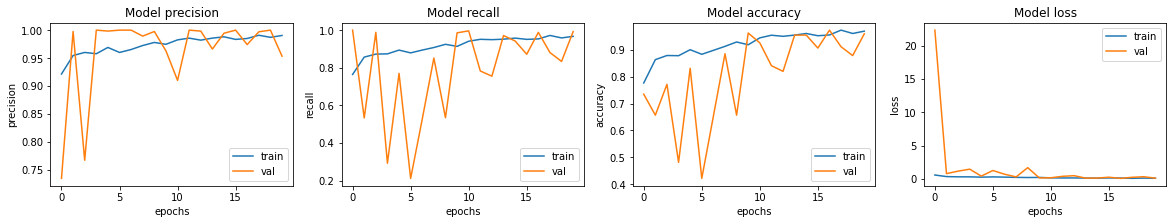

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 5s 60ms/step - loss: 0.7978 - accuracy: 0.7612 - precision: 0.7269 - recall: 0.9897
Loss: 0.7977941036224365,
Accuracy: 0.7612179517745972,
Precision: 0.7269303202629089,
Recall: 0.9897435903549194
